In [1]:
!unzip "flowers.zip" -d "data/"

Archive:  flowers.zip
   creating: data/pic/
   creating: data/pic/train/
   creating: data/pic/train/daisy/
  inflating: data/pic/train/daisy/1.jpg  
  inflating: data/pic/train/daisy/10.jpg  
  inflating: data/pic/train/daisy/100.jpg  
  inflating: data/pic/train/daisy/101.jpg  
  inflating: data/pic/train/daisy/102.jpg  
  inflating: data/pic/train/daisy/103.jpg  
  inflating: data/pic/train/daisy/104.jpg  
  inflating: data/pic/train/daisy/105.jpg  
  inflating: data/pic/train/daisy/106.jpg  
  inflating: data/pic/train/daisy/107.jpg  
  inflating: data/pic/train/daisy/108.jpg  
  inflating: data/pic/train/daisy/109.jpg  
  inflating: data/pic/train/daisy/11.jpg  
  inflating: data/pic/train/daisy/110.jpg  
  inflating: data/pic/train/daisy/111.jpg  
  inflating: data/pic/train/daisy/112.jpg  
 extracting: data/pic/train/daisy/113.jpg  
  inflating: data/pic/train/daisy/114.jpg  
  inflating: data/pic/train/daisy/115.jpg  
  inflating: data/pic/train/daisy/116.jpg  
  inflating: da

In [2]:
from typing import Tuple, Dict, List

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [3]:
def create_model(num_classes: int) -> nn.Module:
    # Loading the pre-trained ViT-B-16 model
    model = torchvision.models.vit_b_16(
        weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
    )

    # speed up training and prevent overfitting
    for param in model.parameters():
        param.requires_grad = False

    for param in model.encoder.layers[-1].parameters():
        param.requires_grad = True

    # Replace classification head
    in_features = model.heads.head.in_features  # Getting the number of input features
    model.heads = nn.Sequential(
        nn.LayerNorm(in_features), # Standardized input
        nn.Linear(in_features, 512), # Fully connected layer
        nn.GELU(), # activation function
        nn.Dropout(0.1), # Preventing overfitting
        nn.Linear(512, num_classes) # Output layer
    )

    return model

# Creating a Data Loader
def create_dataloaders(
    data_dir: str,
    batch_size: int = 32
) -> Tuple[DataLoader, DataLoader, int]:

    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224), # Adjustment to 224x224
        transforms.RandomHorizontalFlip(),  # Random Horizontal Flip
        transforms.RandomRotation(20),  # random rotation
        transforms.RandomAffine(10), # stochastic affine transformation
        transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomize brightness and contrast
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    val_transforms = transforms.Compose([
        transforms.Resize(256), # Resize the image to 256
        transforms.CenterCrop(224), # Cropped from center to 224x224
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    train_dataset = datasets.ImageFolder(
        root=f"{data_dir}/train",
        transform=train_transforms
    )

    val_dataset = datasets.ImageFolder(
        root=f"{data_dir}/validation",
        transform=val_transforms
    )

    num_classes = len(train_dataset.classes)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True, # confuse data
        num_workers=2, # Load data using 4 sub-processes
        pin_memory=True # Speed up data loading by putting data into fixed memory
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader, num_classes

# training model
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 1e-4
) -> Dict[str, List[float]]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss() # Cross Entropy Loss Function

    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=0.01 # L2 regularization
    )

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        model.train() # Switch to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # Empty the gradient
            outputs = model(inputs) # model output
            loss = criterion(outputs, labels) # Calculation of losses
            loss.backward() # backward propagation
            optimizer.step() # Updating parameters

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)

        # validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1) # Get predicted labels
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total # Calculate validation set accuracy

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')
        print(f'Validation Accuracy: {accuracy:.2f}%')
        print('-' * 50)

    return history

# Visualization of predicted results
def visualize_predictions(
    model: nn.Module,
    val_loader: DataLoader,
    class_names: List[str],
    num_images: int = 5
):
    device = next(model.parameters()).device
    model.eval()

    all_images = []
    all_labels = []
    for images, labels in val_loader:
        all_images.extend(images)
        all_labels.extend(labels)

    torch.manual_seed(42)  # Set seed for reproducibility

    indices = torch.randperm(len(all_images))[:num_images]
    images = torch.stack([all_images[i] for i in indices]).to(device)
    labels = torch.tensor([all_labels[i] for i in indices])

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        if num_images == 1:
            ax = axes
        else:
            ax = axes[i]

        ax.imshow(img)
        ax.set_title(
            f'Predicted: {class_names[predicted[i]]}\n'
            f'Actual: {class_names[labels[i]]}'
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 151MB/s]


Epoch [1/5]
Training Loss: 0.4563
Validation Loss: 0.4332
Validation Accuracy: 84.86%
--------------------------------------------------
Epoch [2/5]
Training Loss: 0.2513
Validation Loss: 0.3863
Validation Accuracy: 86.24%
--------------------------------------------------
Epoch [3/5]
Training Loss: 0.1778
Validation Loss: 0.3532
Validation Accuracy: 87.17%
--------------------------------------------------
Epoch [4/5]
Training Loss: 0.1749
Validation Loss: 0.3748
Validation Accuracy: 87.98%
--------------------------------------------------
Epoch [5/5]
Training Loss: 0.1573
Validation Loss: 0.3565
Validation Accuracy: 88.21%
--------------------------------------------------


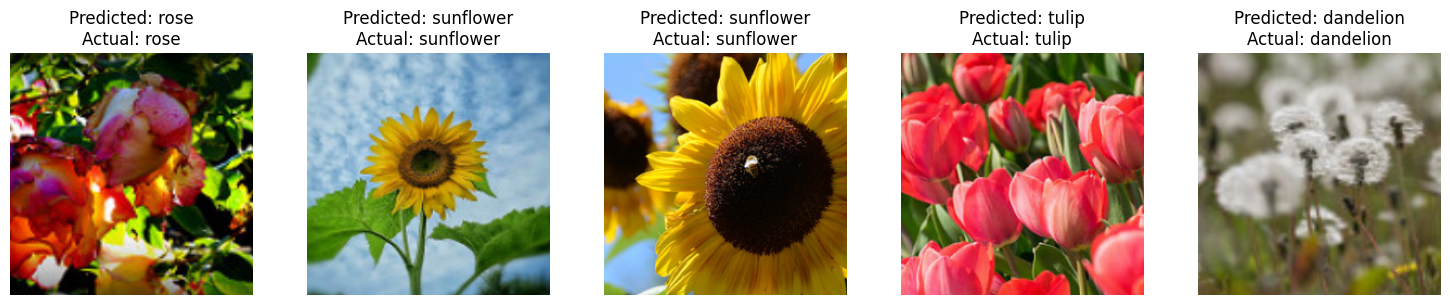

In [4]:
# data catalog
data_dir = "data/pic"

# data loader
train_loader, val_loader, num_classes = create_dataloaders(
    data_dir=data_dir,
    batch_size=16
)

# Creating Models
model = create_model(num_classes=num_classes)

# train models
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5,
    learning_rate=1e-4
)

# Visualize some of the predicted results
class_names = train_loader.dataset.classes
visualize_predictions(
    model=model,
    val_loader=val_loader,
    class_names=class_names,
    num_images=5
)